# Set-up

In [185]:
import os
import yaml
import logging
import numpy as np
import xarray as xr
import seqdata as sd
import seqpro as sp

import scanpy as sc
from anndata import AnnData

from sklearn.model_selection import KFold
from sklearn.decomposition import NMF

from scipy.stats import pearsonr, spearmanr, kendalltau
from scipy.stats import mannwhitneyu, ttest_ind
from scipy.stats import kruskal, f_oneway
from statsmodels.stats.multitest import fdrcorrection

In [186]:
def merge_parameters(parameters, default_parameters):
	"""Merge the provided parameters with the default parameters.

	
	Parameters
	----------
	parameters: str
		Name of the JSON folder with the provided parameters

	default_parameters: dict
		The default parameters for the operation.


	Returns
	-------
	params: dict
		The merged set of parameters.
	"""

	with open(parameters, "r") as infile:
		parameters = yaml.safe_load(infile)

	unset_parameters = ()
	for param_class in default_parameters.keys():
		for parameter, value in default_parameters[param_class].items():
			if parameter not in parameters:
				if value is None and parameter not in unset_parameters:
					raise ValueError("Must provide value for '{}'".format(parameter))

				parameters[param_class][parameter] = value

	return parameters

default_params = {
    "seqdata": {
        "batch_size": 1000,
        "overwrite": False,
    }
}

In [187]:
import pandas as pd

def infer_covariate_types(df: pd.DataFrame, categorical_threshold=0.05):
    """
    Infers the type of covariate for each column in a DataFrame.

    Args:
    - df: Input pandas DataFrame.
    - categorical_threshold: The threshold (as a proportion of the total rows) 
      below which a numeric column is considered categorical. Default is 5%.

    Returns:
    - A dictionary where the keys are column names and the values are the inferred types:
      'binary', 'categorical', or 'continuous'.
    """
    covariate_types = {}

    for col in df.columns:
        # Drop NaN values for proper evaluation
        unique_values = df[col].dropna().unique()
        num_unique = len(unique_values)
        total_rows = df[col].dropna().shape[0]

        # Skip columns with all NaNs
        if total_rows == 0:
            continue

        # Check if column is binary (exactly 2 unique values)
        if num_unique == 2:
            covariate_types[col] = 'binary'

        # Check if column is categorical (non-numeric or few unique values)
        elif pd.api.types.is_numeric_dtype(df[col]):
            # For numeric columns, decide based on the number of unique values
            unique_ratio = num_unique / total_rows

            # If unique_ratio is below a threshold, consider it categorical
            if unique_ratio < categorical_threshold:
                covariate_types[col] = 'categorical'
            else:
                covariate_types[col] = 'continuous'
        else:
            # For non-numeric types, it's considered categorical if there are multiple unique values
            covariate_types[col] = 'categorical' if num_unique > 1 else 'binary'

    return covariate_types

In [188]:
def correlate_cnt_with_continuous(
    cnt,
    covariate,
    normalize=False,
    method="pearson",
):
    """Calculate the correlation between two variables.

    Parameters
    ----------
    cnt: np.ndarray
        The count variable as a 1D numpy array.
    covariate: np.ndarray
        The continuous variable as a 1D numpy array.
    normalize: bool
        Whether to normalize the count so that it sums to 1.
    method: str
        The method to use for correlation. Options are "pearson", "spearman", and "kendall".

    Returns
    -------
    (float, float)
        The correlation coefficient and p-value as a tuple.
    """
    if sum(cnt) == 0:
        return (np.nan, np.nan)
    
    if normalize:
        cnt = cnt / cnt.sum()

    if method == "pearson":
        return pearsonr(cnt, covariate)
    elif method == "spearman":
        return spearmanr(cnt, covariate)
    elif method == "kendall":
        return kendalltau(cnt, covariate)
    else:
        raise ValueError(f"Unknown method: {method}")
    

def run_correlations(
    cnts: np.ndarray,
    covariate: np.ndarray,
    method: str = "pearson",
):
    """Calculate the correlation between each column of counts and a continuous covariate.

    Parameters
    ----------
    counts: np.ndarray
        The count variables as a 2D numpy array.
    covariate: np.ndarray
        The continuous variable as a 1D numpy array.
    method: str
        The method to use for correlation. Options are "pearson", "spearman", and "kendall".

    Returns
    -------
    (np.ndarray, np.ndarray)
        The correlation coefficients and p-values as numpy arrays.
    """
    n = cnts.shape[1]
    corrs = np.zeros(n)
    pvals = np.zeros(n)

    for i in range(n):
        corrs[i], pvals[i] = correlate_cnt_with_continuous(cnts[:, i], covariate, method=method)

    return corrs, pvals


def correlate_cnt_with_binary(
    cnt,
    binary,
    normalize=False,
    method="mannwhitneyu",
):
    """Calculate the correlation between a count variable and a binary variable.

    Parameters
    ----------
    cnt: np.ndarray
        The count variable as a 1D numpy array.
    binary: np.ndarray
        The binary variable as a 1D numpy array.
    normalize: bool
        Whether to normalize the count so that it sums to 1.
    method: str
        The method to use for correlation. Options are "mannwhitneyu", "ttest_ind", "pearson", "spearman", and "kendall".

    Returns
    -------
    (float, float)
        The correlation coefficient and p-value as a tuple.
    """
    if sum(cnt) == 0:
        return (np.nan, np.nan)
    
    if normalize:
        cnt = cnt / cnt.sum()

    if method == "mannwhitneyu":
        return mannwhitneyu(cnt, binary)
    elif method == "ttest_ind":
        return ttest_ind(cnt, binary)
    elif method in ["pearson", "spearman", "kendall"]:
        return correlate_cnt_with_continuous(cnt, binary, normalize=normalize, method=method)
    

def run_binary_correlations(
    cnts: np.ndarray,
    binary: np.ndarray,
    method: str = "mannwhitneyu",
):
    """Calculate the correlation between each column of counts and a binary covariate.

    Parameters
    ----------
    counts: np.ndarray
        The count variables as a 2D numpy array.
    binary: np.ndarray
        The binary variable as a 1D numpy array.
    method: str
        The method to use for correlation. Options are "mannwhitneyu" and "ttest_ind".

    Returns
    -------
    (np.ndarray, np.ndarray)
        The correlation coefficients and p-values as numpy arrays.
    """
    n = cnts.shape[1]
    corrs = np.zeros(n)
    pvals = np.zeros(n)

    for i in range(n):
        corrs[i], pvals[i] = correlate_cnt_with_binary(cnts[:, i], binary, method=method)

    return corrs, pvals


def correlate_cnt_with_categorical(
    cnt,
    categorical,
    normalize=False,
    method="kruskal",
):
    """Calculate the correlation between a count variable and a categorical variable.

    Parameters
    ----------
    cnt: np.ndarray
        The count variable as a 1D numpy array.
    categorical: np.ndarray
        The categorical variable as a 1D numpy array.
    normalize: bool
        Whether to normalize the count so that it sums to 1.
    method: str
        The method to use for correlation. Options are "kruskal" and "f_oneway".

    Returns
    -------
    (float, float)
        The correlation coefficient and p-value as a tuple.
    """
    if sum(cnt) == 0:
        return (np.nan, np.nan)
    
    if normalize:
        cnt = cnt / cnt.sum()

    if method == "kruskal":
        return kruskal(*[cnt[categorical == i] for i in np.unique(categorical)])
    elif method == "f_oneway":
        return f_oneway(*[cnt[categorical == i] for i in np.unique(categorical)])
    else:
        raise ValueError(f"Unknown method: {method}")
    
    
def run_categorical_correlations(
    cnts: np.ndarray,
    categorical: np.ndarray,
    method: str = "kruskal",
):
    """Calculate the correlation between each column of counts and a categorical covariate.

    Parameters
    ----------
    counts: np.ndarray
        The count variables as a 2D numpy array.
    categorical: np.ndarray
        The categorical variable as a 1D numpy array.
    method: str
        The method to use for correlation. Options are "kruskal" and "f_oneway".

    Returns
    -------
    (np.ndarray, np.ndarray)
        The correlation coefficients and p-values as numpy arrays.
    """
    n = cnts.shape[1]
    corrs = np.zeros(n)
    pvals = np.zeros(n)

    for i in range(n):
        corrs[i], pvals[i] = correlate_cnt_with_categorical(cnts[:, i], categorical, method=method)

    return corrs, pvals

# Parameters

In [189]:
path_params = "/cellar/users/aklie/projects/ML4GLand/EUGENe/examples/prep_dataset/yeast_seqs/yeast_seqs.yaml"

In [155]:
with open(path_params, "r") as f:
    params = yaml.safe_load(f)

In [190]:
params = merge_parameters(path_params, default_params)
params

{'base': {'name': 'yeast_seqs',
  'path_out': '/cellar/users/aklie/projects/ML4GLand/EUGENe/examples/prep_dataset/yeast_seqs',
  'overwrite': True},
 'seqdata': {'tables': ['/cellar/users/aklie/projects/ML4GLand/EUGENe/examples/prep_dataset/yeast_seqs/yeast_seqs.txt'],
  'seq_col': 'seq',
  'batch_size': 1000,
  'target_cols': ['target'],
  'additional_cols': ['group', 'condition'],
  'fixed_length': True,
  'alphabet': 'DNA',
  'upper_case': False,
  'add_rev_comp': False,
  'max_jitter': 0,
  'overwrite': False},
 'splits': {'split_col': None,
  'training_frac': 0.9,
  'folds': 10,
  'random_seed': 1234},
 'kmer_analysis': {'k': [5], 'normalize': True},
 'motif_analysis': {'motif_database': '/cellar/users/aklie/opt/miniconda3/envs/eugene_tools/lib/python3.11/site-packages/polygraph/resources/jaspar/JASPAR2024_CORE_fungi_non-redundant_pfms_meme.txt',
  'sig': '1e-3',
  'normalize': True,
  'n_components': 10}}

In [157]:
# Infer seqpro alphabet
if params["seqdata"]["alphabet"] == "DNA":
    alphabet = sp.DNA
elif params["seqdata"]["alphabet"] == "RNA":
    alphabet = sp.RNA

# Logging

In [124]:
# Set-up logging with date and time
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

In [125]:
# Log parameters
logging.info("Parameters:")
for key, value in params.items():
    logging.info(f"  {key}")
    for key, value in value.items():
        logging.info(f"    {key}: {value}")

2024-10-22 09:28:47,030 - INFO - Parameters:
2024-10-22 09:28:47,031 - INFO -   base
2024-10-22 09:28:47,032 - INFO -     name: yeast_seqs
2024-10-22 09:28:47,033 - INFO -     path_out: /cellar/users/aklie/projects/ML4GLand/EUGENe/examples/prep_dataset/yeast_seqs
2024-10-22 09:28:47,031 - INFO -   base
2024-10-22 09:28:47,032 - INFO -     name: yeast_seqs
2024-10-22 09:28:47,033 - INFO -     path_out: /cellar/users/aklie/projects/ML4GLand/EUGENe/examples/prep_dataset/yeast_seqs
2024-10-22 09:28:47,033 - INFO -     overwrite: True
2024-10-22 09:28:47,034 - INFO -   seqdata
2024-10-22 09:28:47,034 - INFO -     tables: ['/cellar/users/aklie/projects/ML4GLand/EUGENe/examples/prep_dataset/yeast_seqs/yeast_seqs.txt']
2024-10-22 09:28:47,035 - INFO -     seq_col: seq
2024-10-22 09:28:47,036 - INFO -     batch_size: 300
2024-10-22 09:28:47,036 - INFO -     target_cols: ['target']
2024-10-22 09:28:47,037 - INFO -     additional_cols: ['group', 'condition']
2024-10-22 09:28:47,037 - INFO -     f

# Load SeqData

In [126]:
out = os.path.join(params["base"]["path_out"], f"{params['base']['name']}.seqdata")
logging.info(f"Writing to {out}")

2024-10-22 09:28:47,715 - INFO - Writing to /cellar/users/aklie/projects/ML4GLand/EUGENe/examples/prep_dataset/yeast_seqs/yeast_seqs.seqdata


In [127]:
seq_col = params["seqdata"]["seq_col"]
fixed_length = params["seqdata"]["fixed_length"]

In [128]:
sdata = sd.read_table(
    name=params["seqdata"]["seq_col"],
    out=out,
    tables=params["seqdata"]["tables"],
    seq_col=seq_col,
    fixed_length=fixed_length,
    batch_size=params["seqdata"]["batch_size"],
    overwrite=params["base"]["overwrite"],
)
sdata

300it [00:00, 4323.33it/s]


<xarray.Dataset>
Dimensions:    (_sequence: 300, _length: 80)
Dimensions without coordinates: _sequence, _length
Data variables:
    condition  (_sequence) object dask.array<chunksize=(300,), meta=np.ndarray>
    group      (_sequence) object dask.array<chunksize=(300,), meta=np.ndarray>
    seq        (_sequence, _length) |S1 dask.array<chunksize=(300, 80), meta=np.ndarray>
    target     (_sequence) float64 dask.array<chunksize=(300,), meta=np.ndarray>

# Splits

In [129]:
splits = params["splits"]["folds"]
random_state = params["splits"]["random_seed"]

In [130]:
# Split into folds such that no two decoded seqs are in the same fold
seqs_idxs = np.arange(sdata.dims["_sequence"])
skf = KFold(n_splits=splits, shuffle=True, random_state=random_state)
train_seq_per_fold = {}
valid_seq_per_fold = {}
for i, (train_seq, valid_seq) in enumerate(skf.split(seqs_idxs)):
    train_seq_per_fold[i] = [seqs_idxs[j] for j in train_seq] 
    valid_seq_per_fold[i] = [seqs_idxs[j] for j in valid_seq]

# Label the folds for each sequence using the idxs
for i in range(10):
    sdata[f"fold_{i}"] = xr.DataArray(np.zeros(sdata.dims["_sequence"], dtype=bool), dims=["_sequence"])
    sdata[f"fold_{i}"].loc[{"_sequence": train_seq_per_fold[i]}] = True

# Double check that folds make sense
sdata[["fold_0", "fold_1", "fold_2", "fold_3", "fold_4", "fold_5", "fold_6", "fold_7", "fold_8", "fold_9"]].to_pandas().describe()

,fold_0,fold_1,fold_2,fold_3,fold_4,fold_5,fold_6,fold_7,fold_8,fold_9
count,300,300,300,300,300,300,300,300,300,300
unique,2,2,2,2,2,2,2,2,2,2
top,True,True,True,True,True,True,True,True,True,True
freq,270,270,270,270,270,270,270,270,270,270


# Save minimal SeqData

In [131]:
# Save
sd.to_zarr(sdata, out.replace(".seqdata", ".minimal.seqdata"))

/cellar/users/aklie/opt/miniconda3/envs/eugene_tools/lib/python3.11/site-packages/xarray/conventions.py:112: SerializationWarning: variable None has data in the form of a dask array with dtype=object, which means it is being loaded into memory to determine a data type that can be safely stored on disk. To avoid this, coerce this variable to a fixed-size dtype with astype() before saving it.
  warnings.warn(
/cellar/users/aklie/opt/miniconda3/envs/eugene_tools/lib/python3.11/site-packages/xarray/conventions.py:112: SerializationWarning: variable None has data in the form of a dask array with dtype=object, which means it is being loaded into memory to determine a data type that can be safely stored on disk. To avoid this, coerce this variable to a fixed-size dtype with astype() before saving it.
  warnings.warn(


In [132]:
sdata.coords["_sequence"] = np.array([f"seq_{i}" for i in range(sdata.dims["_sequence"])])
sdata

<xarray.Dataset>
Dimensions:    (_sequence: 300, _length: 80)
Coordinates:
  * _sequence  (_sequence) <U7 'seq_0' 'seq_1' 'seq_2' ... 'seq_298' 'seq_299'
Dimensions without coordinates: _length
Data variables: (12/14)
    condition  (_sequence) object dask.array<chunksize=(300,), meta=np.ndarray>
    group      (_sequence) object dask.array<chunksize=(300,), meta=np.ndarray>
    seq        (_sequence, _length) |S1 dask.array<chunksize=(300, 80), meta=np.ndarray>
    target     (_sequence) float64 dask.array<chunksize=(300,), meta=np.ndarray>
    fold_0     (_sequence) bool True True True True True ... True True True True
    fold_1     (_sequence) bool True True True True ... True False True True
    ...         ...
    fold_4     (_sequence) bool True True True True True ... True True True True
    fold_5     (_sequence) bool True True False True ... True True True True
    fold_6     (_sequence) bool True False True True ... True True True True
    fold_7     (_sequence) bool False True True True ... True True False True
    fold_8     (_sequence) bool True True True True ... True True True False
    fold_9     (_sequence) bool True True True False ... True True True True

# One-hot encode

In [133]:
sdata["ohe"] = xr.DataArray(sp.ohe(sdata[seq_col].values, alphabet=alphabet), dims=["_sequence", "_length", "_alphabet"])
sdata.coords["_alphabet"] = alphabet.array

# Sequence analysis pipeline

## Infer coveriate types

In [134]:
# Get all covariates that isn't fold, seq_col or ohe
covariates = [col for col in sdata.data_vars if col not in [seq_col, "ohe"]]
covariates = [col for col in covariates if not col.startswith("fold")]
covariates

['condition', 'group', 'target']

In [135]:
# Infer the type of each covariate as categorical, binary, continuous (create a dictionary)
covariate_types = infer_covariate_types(sdata[covariates].to_pandas())
covariate_types

{'condition': 'binary', 'group': 'categorical', 'target': 'continuous'}

## Get seqs, targets and metadata

In [136]:
# Get the number of sequences and the fixed length of each sequence
seqs = sdata[params["seqdata"]["seq_col"]].values
dims = seqs.shape

In [137]:
if len(dims) == 2:
    seqs = seqs.view('S{}'.format(dims[1])).ravel().astype(str)
seqs.shape

(300,)

In [138]:
if len(params["seqdata"]["target_cols"]) > 0:
    targets = sdata[params["seqdata"]["target_cols"]].to_pandas()
else:    
    targets = None
targets.shape

(300, 1)

In [139]:
if len(params["seqdata"]["additional_cols"]) > 0:
    metadata = sdata[params["seqdata"]["additional_cols"]].to_pandas()
else:
    metadata = None
metadata.shape

(300, 2)

## Sequence length distributions

In [140]:
sdata["length"] = xr.DataArray(sp.length(seqs), dims=["_sequence"])
covariate_types["length"] = "continuous"

## Character distributions

In [141]:
# Get unique characters in the sequences with numpy
unique_chars = np.unique(list("".join(seqs)))
unique_chars

array(['A', 'C', 'G', 'T'], dtype='<U1')

In [142]:
sdata["alphabet_cnt"] = xr.DataArray(sp.nucleotide_content(seqs, normalize=False, alphabet=alphabet, length_axis=-1), dims=["_sequence", "_alphabet"])
sdata["non_alphabet_cnt"] = sdata["length"] - sdata["alphabet_cnt"].sum(axis=-1)
if params["seqdata"]["alphabet"] == "DNA" or params["seqdata"]["alphabet"] == "RNA":
    sdata["gc_percent"] = sdata["alphabet_cnt"].sel(_alphabet=[b"G", b"C"]).sum(axis=-1) / sdata["length"]
    covariate_types["gc_percent"] = "continuous"

## K-mer distribution analysis

In [143]:
import polygraph.sequence
import seqpro as sp
from seqpro._analyzers import count_kmers_seq

In [144]:
ks = params["kmer_analysis"]["k"]
normalize = params["kmer_analysis"]["normalize"]

In [145]:
# eventually want to replace this with a more efficient implementation with count_kmers_seq(seqs[0], k=5)
# Structure of output is nested dictionary with 
# level 1 keys: kmer length, level 1 values: dictionary with
# level 2 keys: covariate type, level 2 values: dictionary with
# level 3 keys: covariate name, level 3 values: pandas DataFrame with stats
kmer_res = {}
for k in ks:

    # Compute the k-mer frequencies
    kmers = polygraph.sequence.kmer_frequencies(seqs=seqs.tolist(), k=k, normalize=False)

    # Add the k-mer counts to the seqdata
    sdata[f"{k}mer_cnt"] = xr.DataArray(kmers.values, dims=["_sequence", f"_{k}mer"])
    sdata.coords[f"_{k}mer"] = kmers.columns

    # If normalize, normalize the k-mer counts by sequence lengths
    if normalize:
        kmers = kmers.div(sdata["length"].values - k + 1, axis=0)

    # Run PCA on the k-mer counts
    ad = AnnData(kmers, obs=sdata[covariate_types.keys()].to_pandas(), var=sdata[f"_{k}mer"].to_pandas().index.to_frame().drop(f"_{k}mer", axis=1))
    ad = ad[:, ad.X.sum(0) > 0]
    sc.pp.pca(ad)

    # For each continuous variable, run correlations with each count
    continuous_res = {}
    for covariate, covariate_type in covariate_types.items():
        if covariate_types[covariate] == "continuous":
            corrs, pvals = run_correlations(
                cnts=sdata[f"{k}mer_cnt"].values,
                covariate=sdata[covariate].values,
                method="pearson",
            )
            continuous_res[covariate] = pd.DataFrame(
                {
                    f"{k}mer": sdata.coords[f"_{k}mer"].values,
                    "corr": corrs,
                    "pval": pvals,
                }
            )
            continuous_res[covariate] = continuous_res[covariate].sort_values("corr", ascending=False)

    # For each binary variable, run correlations with each count
    binary_res = {}
    for covariate, covariate_type in covariate_types.items():
        if covariate_types[covariate] == "binary":
            # Binarize the covariate
            covariate_ = sdata[covariate].values
            covariate_ = covariate_ == covariate_.max()
            corrs, pvals = run_binary_correlations(
                cnts=sdata[f"{k}mer_cnt"].values,
                binary=covariate_,
                method="mannwhitneyu",
            )
            binary_res[covariate] = pd.DataFrame(
                {
                    f"{k}mer": sdata.coords[f"_{k}mer"].values,
                    "corr": corrs,
                    "pval": pvals,
                }
            )
            binary_res[covariate] = binary_res[covariate].sort_values("corr", ascending=False)

    # For each categorical variable, run correlations with each count
    categorical_res = {}
    diff_res = {}
    for covariate, covariate_type in covariate_types.items():
        if covariate_types[covariate] == "categorical":

            # Run the correlation
            corrs, pvals = run_categorical_correlations(
                cnts=sdata[f"{k}mer_cnt"].values,
                categorical=sdata[covariate].values,
                method="kruskal",
            )
            categorical_res[covariate] = pd.DataFrame(
                {
                    f"{k}mer": sdata.coords[f"_{k}mer"].values,
                    "corr": corrs,
                    "pval": pvals,
                }
            )
            categorical_res[covariate] = categorical_res[covariate].sort_values("corr", ascending=False)
        
            # Run the differential analysis
            sc.tl.rank_genes_groups(
                ad,
                groupby=covariate,
                groups="all",
                reference="rest",
                rankby_abs=True,
                method="wilcoxon",
            )
            
            # Get the variable names
            diff = pd.DataFrame(ad.uns["rank_genes_groups"]["names"]).melt(var_name="group")

            # Get the statistics
            diff["score"] = pd.DataFrame(ad.uns["rank_genes_groups"]["scores"]).melt()["value"]
            diff["padj"] = pd.DataFrame(ad.uns["rank_genes_groups"]["pvals_adj"]).melt()["value"]
            diff["log2FC"] = pd.DataFrame(ad.uns["rank_genes_groups"]["logfoldchanges"]).melt()["value"]
            diff_res[covariate] = diff


    kmer_res[k] = {
        "continuous": continuous_res,
        "binary": binary_res,
        "categorical": categorical_res,
        "diff": diff_res,
    }

/cellar/users/aklie/opt/miniconda3/envs/eugene_tools/lib/python3.11/site-packages/scanpy/preprocessing/_pca.py:317: ImplicitModificationWarning: Setting element `.obsm['X_pca']` of view, initializing view as actual.
  adata.obsm[key_obsm] = X_pca
/tmp/ipykernel_140065/2513480686.py:32: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  return pearsonr(cnt, covariate)
... storing 'condition' as categorical
... storing 'group' as categorical


## Motif analysis

In [146]:
from tangermeme.tools.fimo import fimo

In [147]:
meme_file = params["motif_analysis"]["motif_database"]
sig = float(params["motif_analysis"]["sig"])

In [162]:
# Perform FIMO
X = sp.ohe(seqs, alphabet=alphabet).transpose(0, 2, 1)
hits = fimo(meme_file, X) 

# Count up significant occurences of motif
motif_match_df = pd.concat([hit for hit in hits])
motif_match_df_ = motif_match_df.loc[motif_match_df["p-value"] < sig]
print(f"There are {motif_match_df_.shape[0]} significant motif matches.")
motif_match_df_ = motif_match_df.value_counts(subset=['sequence_name', "motif_name"]).reset_index()
motif_match_df_.columns = ['sequence_name', "motif_name", 'motif_count']
motif_match_df_ = motif_match_df_.pivot(index='sequence_name', columns="motif_name", values='motif_count')
motif_count_df = pd.DataFrame(index=range(len(seqs)), columns=motif_match_df_.columns)
motif_count_df.loc[motif_match_df_.index.values] = motif_match_df_
motif_count_df = motif_count_df.fillna(0)

# Add to seqdata
sdata["motif_cnt"] = xr.DataArray(motif_count_df.values, dims=["_sequence", "_motif"])
sdata.coords["_motif"] = motif_count_df.columns.values
sdata.attrs["motif_database"] = meme_file

# If normalize, normalize the motif counts by sequence lengths
if normalize:
    motif_count_df = motif_count_df.div(sdata["length"].values, axis=0)

# Run PCA on the motif counts
ad = AnnData(motif_count_df.values, obs=sdata[covariate_types.keys()].to_pandas(), var=pd.DataFrame(index=sdata.coords["_motif"].values))
ad = ad[:, ad.X.sum(0) > 0]
sc.pp.pca(ad)

/tmp/ipykernel_140065/2173474821.py:6: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  motif_match_df = pd.concat([hit for hit in hits])
/tmp/ipykernel_140065/2173474821.py:14: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  motif_count_df = motif_count_df.fillna(0)


There are 976 significant motif matches.


/cellar/users/aklie/opt/miniconda3/envs/eugene_tools/lib/python3.11/site-packages/scanpy/preprocessing/_pca.py:317: ImplicitModificationWarning: Setting element `.obsm['X_pca']` of view, initializing view as actual.
  adata.obsm[key_obsm] = X_pca


## NMF

In [158]:
# normalize counts by sequence length
n_components = params["motif_analysis"]["n_components"]

In [159]:
# Run NMF
model = NMF(n_components=n_components, init="random", random_state=0)

# Obtain W and H matrices
W = pd.DataFrame(model.fit_transform(motif_count_df.values))  # seqs x factors
H = pd.DataFrame(model.components_)  # factors x motifs

# Format W and H matrices
factors = [f"factor_{i}" for i in range(n_components)]
W.index = sdata["_sequence"].values
W.columns = factors
H.index = factors
H.columns = sdata["_motif"].values

W.shape, H.shape

((300, 10), (10, 113))

In [164]:
sdata["seq_scores"] = xr.DataArray(W.values, dims=["_sequence", "_factor"])
sdata["motif_loadings"] = xr.DataArray(H.values, dims=["_factor", "_motif"])
sdata.coords["_factor"] = factors

# Save

In [165]:
sdata

<xarray.Dataset>
Dimensions:           (_sequence: 300, _length: 80, _alphabet: 4, _5mer: 1024,
                       _motif: 113, _factor: 10)
Coordinates:
  * _sequence         (_sequence) <U7 'seq_0' 'seq_1' ... 'seq_298' 'seq_299'
  * _alphabet         (_alphabet) |S1 b'A' b'C' b'G' b'T'
  * _5mer             (_5mer) object 'AAAAA' 'AAAAC' 'AAAAG' ... 'TTTTG' 'TTTTT'
  * _motif            (_motif) object 'MA0265.3 ABF1' ... 'MA1437.2 wc-1'
  * _factor           (_factor) <U8 'factor_0' 'factor_1' ... 'factor_9'
Dimensions without coordinates: _length
Data variables: (12/23)
    condition         (_sequence) object dask.array<chunksize=(300,), meta=np.ndarray>
    group             (_sequence) object dask.array<chunksize=(300,), meta=np.ndarray>
    seq               (_sequence, _length) |S1 dask.array<chunksize=(300, 80), meta=np.ndarray>
    target            (_sequence) float64 dask.array<chunksize=(300,), meta=np.ndarray>
    fold_0            (_sequence) bool True True True True ... True True True
    fold_1            (_sequence) bool True True True True ... False True True
    ...                ...
    non_alphabet_cnt  (_sequence) int64 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0
    gc_percent        (_sequence) float64 0.3375 0.2625 0.4625 ... 0.5 0.4625
    5mer_cnt          (_sequence, _5mer) int64 1 0 0 1 0 0 0 1 ... 0 0 0 0 1 0 0
    motif_cnt         (_sequence, _motif) float64 1.0 0.0 0.0 ... 0.0 0.0 0.0
    seq_scores        (_sequence, _factor) float64 0.0 0.09855 ... 0.0 0.03605
    motif_loadings    (_factor, _motif) float64 0.0 0.0 0.0001223 ... 0.0 0.0
Attributes:
    motif_database:  /cellar/users/aklie/opt/miniconda3/envs/eugene_tools/lib...

In [166]:
sd.to_zarr(sdata, out.replace(".seqdata", ".full.seqdata"))

/cellar/users/aklie/opt/miniconda3/envs/eugene_tools/lib/python3.11/site-packages/xarray/conventions.py:112: SerializationWarning: variable None has data in the form of a dask array with dtype=object, which means it is being loaded into memory to determine a data type that can be safely stored on disk. To avoid this, coerce this variable to a fixed-size dtype with astype() before saving it.
  warnings.warn(
/cellar/users/aklie/opt/miniconda3/envs/eugene_tools/lib/python3.11/site-packages/xarray/conventions.py:112: SerializationWarning: variable None has data in the form of a dask array with dtype=object, which means it is being loaded into memory to determine a data type that can be safely stored on disk. To avoid this, coerce this variable to a fixed-size dtype with astype() before saving it.
  warnings.warn(


In [169]:
metadata.to_csv(out.replace(".seqdata", ".metadata.csv"))

In [170]:
from scipy.io import mmwrite

In [176]:
kmer_cnt.shape

(300, 1024)

In [181]:
for k in ks:
    kmer_cnt = sdata[f"{k}mer_cnt"].values
    mmwrite(out.replace(".seqdata", f".{k}mer_cnt.mtx"), kmer_cnt)
    pd.DataFrame(sdata.coords[f"_{k}mer"].values).to_csv(out.replace(".seqdata", f".{k}mers.tsv.gz"), sep="\t", index=False, header=False, compression="gzip")
    pd.DataFrame(sdata["_sequence"].values).to_csv(out.replace(".seqdata", f".seqs.tsv.gz"), sep="\t", index=False, header=False, compression="gzip")

In [182]:
motif_cnt = sdata["motif_cnt"].values
mmwrite(out.replace(".seqdata", ".motif_cnt.mtx"), motif_cnt)
pd.DataFrame(sdata.coords["_motif"].values).to_csv(out.replace(".seqdata", ".motifs.tsv.gz"), sep="\t", index=False, header=False, compression="gzip")

# DONE!

---

In [ ]:
# Add group IDs to W
W[group_col] = sdata[group_col].values.tolist()

In [ ]:
# normalize counts by sequence length

In [522]:
W.index.name = "SeqID"

In [523]:
from scipy.cluster.hierarchy import dendrogram, linkage
reorder = True

In [524]:
groups = W.iloc[:, -1].values
W = W.iloc[:, :-1]

if reorder:
    # cluster and get dendrogram
    Z = linkage(W, "ward")
    order = dendrogram(Z, no_plot=True)["leaves"]

    # reorder by cluster
    W = W.iloc[order, :]
    groups = groups[order]

    # get index ordering for plot
    order_dict = dict()
    for group in np.unique(groups):
        sub = W[groups == group]
        order_dict.update(dict(zip(sub.index.values, range(len(sub)))))

# normalize
W_norm = W.div(W.sum(axis=1), axis=0)

# Melt dataframe
W_norm["Group"] = groups
W_norm = W_norm.reset_index().melt(id_vars=["SeqID", "Group"])

if order:
    W_norm["order"] = W_norm["SeqID"].map(order_dict)

g = (
    p9.ggplot(
        W_norm,
        p9.aes(x="order" if reorder else "SeqID", y="value", fill="variable"),
    )
    + p9.geom_col()
    + p9.facet_wrap("Group", scales="free_x")
    + p9.theme_classic()
    + p9.theme(axis_text_x=p9.element_blank())
    + p9.labels.xlab("Sequence")
    + p9.labels.ylab("Factor proportion")
)

In [530]:
W.sum(axis=1).sort_values(ascending=False)

SeqID
seq_242    0.467737
seq_32     0.458440
seq_168    0.400708
seq_192    0.390645
seq_20     0.349791
             ...   
seq_100    0.000000
seq_101    0.000000
seq_109    0.000000
seq_112    0.000000
seq_160    0.000000
Length: 300, dtype: float64

In [ ]:
# Add group IDs to W
W[group_col] = seqs[group_col].tolist()

# Significance testing between groups
res = pd.DataFrame()
for col in W.columns[:-1]:
    # For each factor, test whether its abundance differs between groups
    factor_res = groupwise_mann_whitney(
        W, val_col=col, reference_group=reference_group, group_col=group_col
    )
    factor_res["factor"] = col
    res = pd.concat([res, factor_res])

# FDR correction
res["padj"] = fdrcorrection(res.pval)[1]

In [ ]:
import p

In [493]:
df = pd.DataFrame(
    index=sdata["_sequence"].values,
    data={
        "group": sdata[group_col].values,
    },
)

In [495]:
df.index.name = "SeqID"

In [502]:
df

,group
SeqID,
seq_0,native_high
seq_1,native_high
seq_2,native_high
seq_3,native_high
seq_4,native_high
...,...
seq_295,guided_evolution
seq_296,guided_evolution
seq_297,guided_evolution


In [504]:
motif_count_df.index = sdata["_sequence"].values
motif_count_df.index.name = "SeqID"

In [497]:
import polygraph.motifs

In [507]:
W, H, test_results = polygraph.motifs.nmf(motif_count_df, df, reference_group='native_high', group_col="group", n_components=10)

In [508]:
W

,factor_0,factor_1,factor_2,factor_3,factor_4,factor_5,factor_6,factor_7,factor_8,factor_9,group
SeqID,,,,,,,,,,,
seq_0,0.000000,0.881443,0.000000,0.030307,0.000000,0.000000,0.000000,0.000000,0.000000,0.780848,native_high
seq_1,0.065589,1.408961,0.000000,0.000000,0.059741,0.000000,0.394384,0.000000,0.083160,0.000000,native_high
seq_2,0.044119,0.228714,0.000000,0.000000,0.058079,0.000000,0.055471,0.000000,0.054294,0.000000,native_high
seq_3,0.000000,0.881443,0.000000,0.030307,0.000000,0.000000,0.000000,0.000000,0.000000,0.780848,native_high
seq_4,0.000000,0.000000,0.000000,0.000000,0.000000,0.401472,0.000000,0.498622,0.081609,0.000000,native_high
...,...,...,...,...,...,...,...,...,...,...,...
seq_295,0.000000,0.000000,0.000000,0.000000,1.255595,0.000000,0.000000,0.511273,0.062275,0.161343,guided_evolution
seq_296,0.000000,0.574778,0.000000,0.063315,0.000000,0.000000,1.475956,0.002602,0.000000,0.451244,guided_evolution
seq_297,0.000000,0.000000,0.005074,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.668323,guided_evolution


In [509]:
H.shape

(10, 113)

In [510]:
import polygraph.visualize

/cellar/users/aklie/opt/miniconda3/envs/eugene_tools/lib/python3.11/site-packages/plotnine/layer.py:344: PlotnineWarning: position_stack : Removed 450 rows containing missing values.
2024-10-21 16:12:25,198 - INFO - Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt


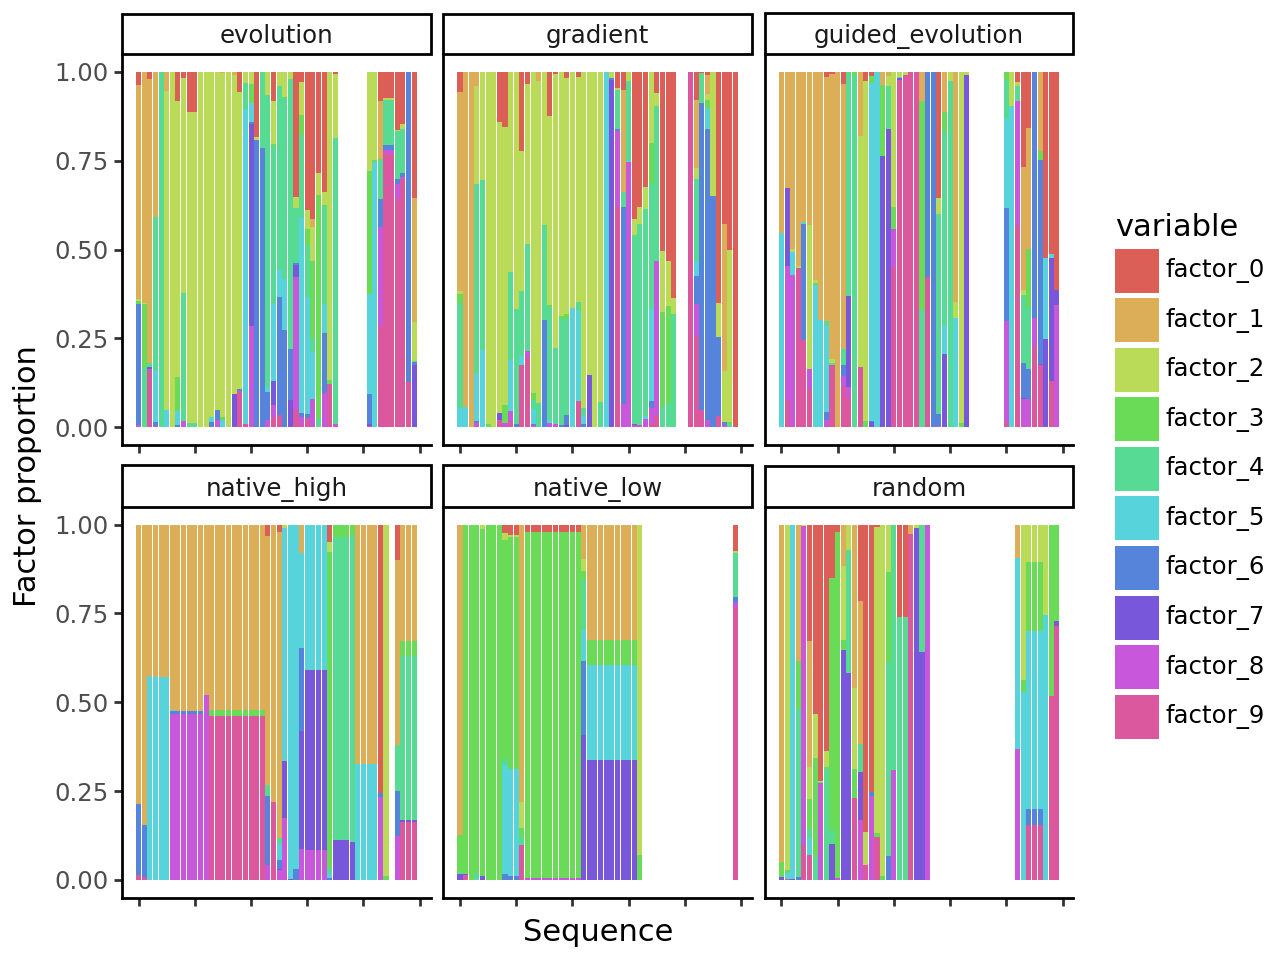

In [511]:
polygraph.visualize.plot_seqs_nmf(W)

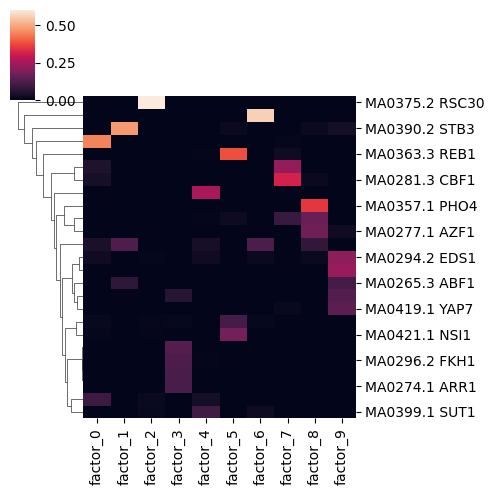

In [488]:
# Motifs that contribute to each factor
polygraph.visualize.plot_factors_nmf(H, n_features=25, figsize=(5,5))

In [230]:
%%time
emb = polygraph.embedding.embedding_analysis(
    motif_count_df, df, reference_group='native_high', use_pca=True, group_col='group')

Creating AnnData object
PCA
Fraction of total variance explained by PCA components:  0.9419630709594248
UMAP


/cellar/users/aklie/opt/miniconda3/envs/eugene_tools/lib/python3.11/site-packages/scanpy/preprocessing/_pca.py:317: ImplicitModificationWarning: Setting element `.obsm['X_pca']` of view, initializing view as actual.
/cellar/users/aklie/opt/miniconda3/envs/eugene_tools/lib/python3.11/site-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
... storing 'group' as categorical


Differential feature abundance
1-NN statistics
Within-group KNN diversity
Euclidean distance to nearest reference
Train groupwise classifiers


/cellar/users/aklie/opt/miniconda3/envs/eugene_tools/lib/python3.11/site-packages/scikit_posthocs/_posthocs.py:357: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
/cellar/users/aklie/opt/miniconda3/envs/eugene_tools/lib/python3.11/site-packages/scikit_posthocs/_posthocs.py:360: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
/cellar/users/aklie/opt/miniconda3/envs/eugene_tools/lib/python3.11/site-packages/scikit_posthocs/_posthocs.py:357: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=Tru

CPU times: user 3.6 s, sys: 603 ms, total: 4.2 s
Wall time: 2.97 s


2024-10-20 20:09:37,288 - INFO - Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt


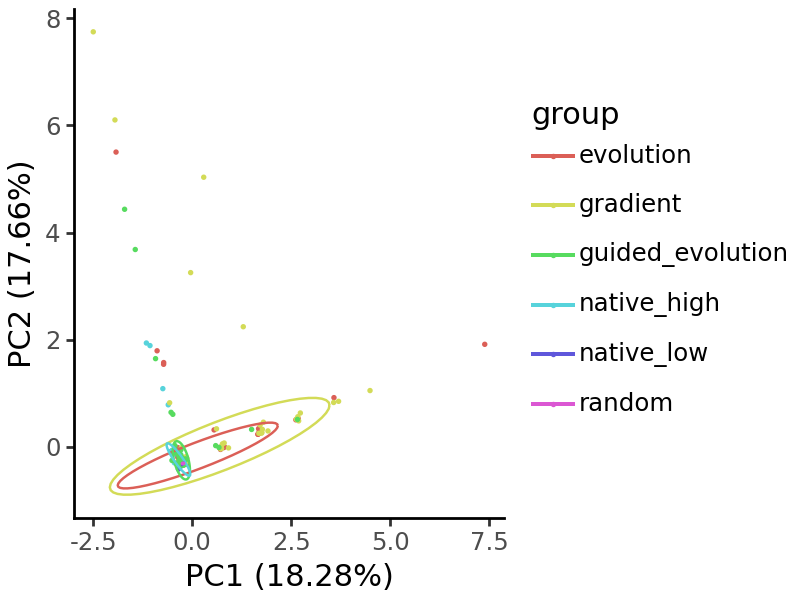

In [232]:
polygraph.visualize.pca_plot(emb, group_col="group") + p9.theme(figure_size=(4,3))

2024-10-20 20:09:56,678 - INFO - Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt


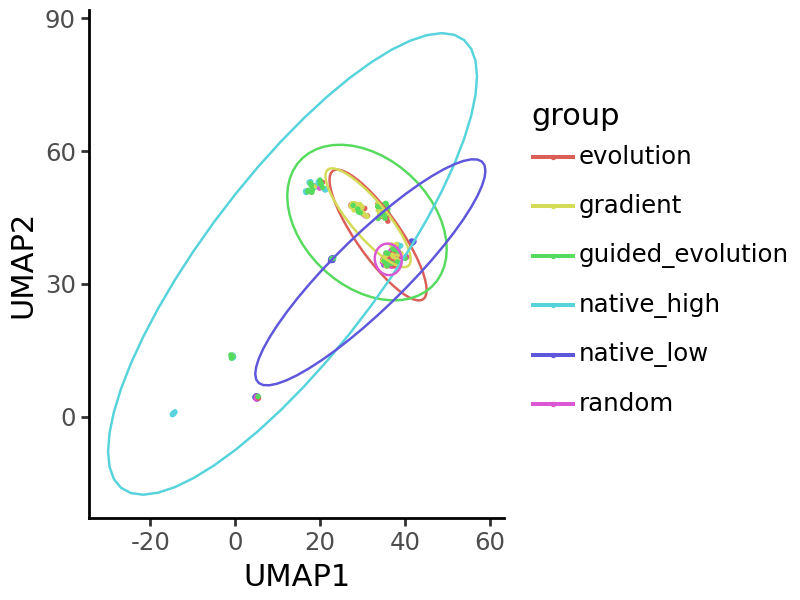

In [234]:
polygraph.visualize.umap_plot(emb, group_col="group") + p9.theme(figure_size=(4,3))

In [226]:
import plotnine as p9

/cellar/users/aklie/opt/miniconda3/envs/eugene_tools/lib/python3.11/site-packages/plotnine/layer.py:344: PlotnineWarning: position_stack : Removed 450 rows containing missing values.
2024-10-20 20:08:07,398 - INFO - Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt


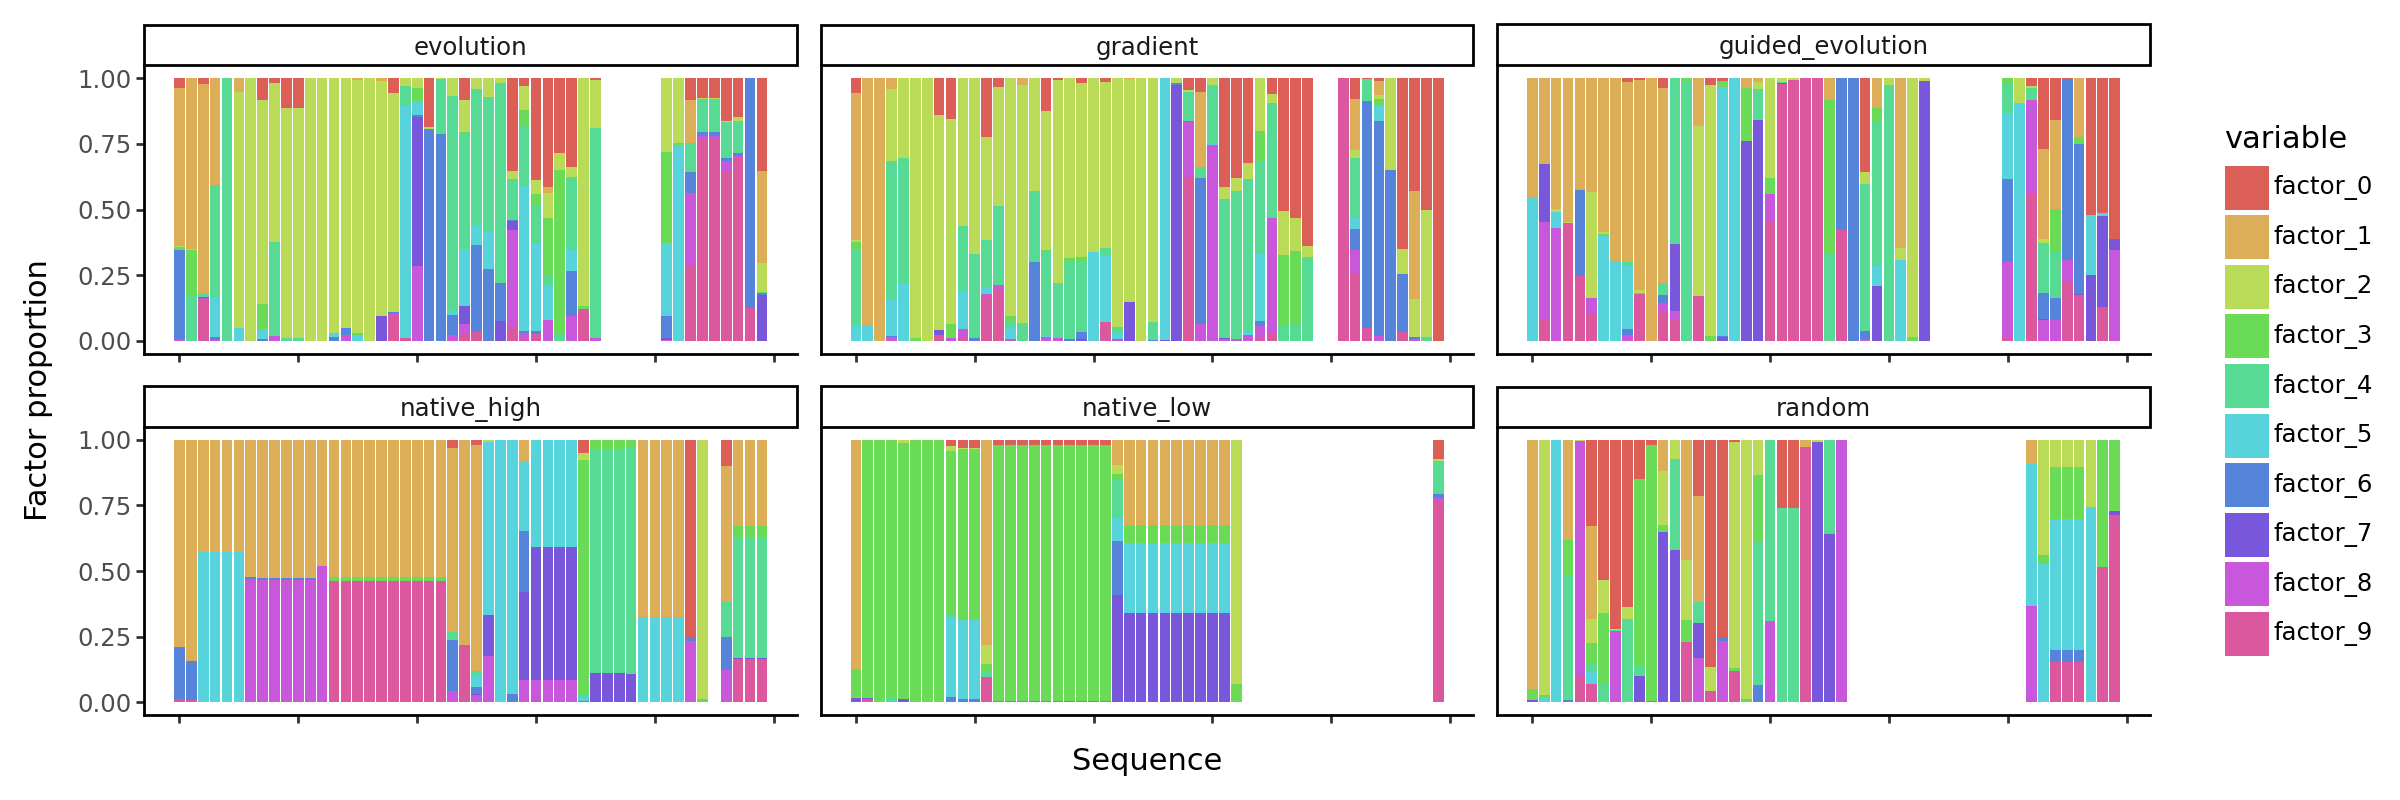

In [227]:
polygraph.visualize.plot_seqs_nmf(W) + p9.theme(figure_size=(12, 4))

In [236]:
test_results = emb.uns["DE_test"]
test_results

,group,value,score,padj,log2FC
0,evolution,MA0390.2 STB3,-3.653724,0.029206,-2.901864
1,evolution,MA0265.3 ABF1,-2.585182,0.366600,-4.222530
2,evolution,MA0375.2 RSC30,2.585182,0.366600,29.917059
3,evolution,MA1436.2 nuc-1,-2.068146,1.000000,-3.877600
4,evolution,MA0363.3 REB1,-1.751030,1.000000,-3.208031
...,...,...,...,...,...
560,random,MA0324.1 LEU3,0.000000,1.000000,0.000000
561,random,MA0403.3 TBF1,0.000000,1.000000,0.000000
562,random,MA0320.1 IME1,0.000000,1.000000,0.000000
563,random,MA0318.1 HMRA2,0.000000,1.000000,0.000000


In [ ]:
import pandas as pd


Caching the list of root modules, please wait!
(This will only be done once - type '%rehashx' to reset cache!)



In [ ]:
test = pd.read_csv(params["seqdata"]["tables"][0], sep="\t")


In [ ]:
params["seqdata"]["tables"][0].replace(".tsv", "_with_targets.tsv")

'/cellar/users/aklie/projects/ML4GLand/EUGENe/examples/prep_dataset/yeast_seqs/yeast_seqs.txt'

In [ ]:
# sample target from a mix of gaussian distributions corresponding to the different classes ("group")
np.random.seed(1234)
classes = test["group"].unique()
means = np.random.uniform(0, 10, len(classes))
stds = np.random.uniform(0.1, 1, len(classes))
n_samples = len(test)
test["target"] = [np.random.normal(means[classes == c], stds[classes == c]) for c in test["group"]]
test["target"] = test["target"].apply(lambda x: x[0])
test.to_csv(params["seqdata"]["tables"][0].replace(".tsv", "_with_targets.tsv"), sep="\t", index=False)

In [ ]:
import plotnine as p9

group_col="group"
components=[0, 1]
size=0.1
show_ellipse=True
reference_group=None

df = pd.DataFrame(ad.obsm["X_pca"][:, components])
var = np.round(ad.uns["pca"]["variance_ratio"] * 100, 2)[components]

# Make axis labels
col1 = f"PC{(components[0] + 1)}"
col2 = f"PC{(components[1] + 1)}"
xlab = col1 + f" ({str(var[0])}%)"
ylab = col2 + f" ({str(var[1])}%)"
df.columns = [col1, col2]
df[group_col] = ad.obs[group_col].tolist()
if reference_group is not None:
    df = pd.concat(
        [df[df[group_col] == reference_group], df[df[group_col] != reference_group]]
    )

# Plot
g = (
    p9.ggplot(df, p9.aes(x=col1, y=col2, color=group_col))
    + p9.geom_point(size=size)
    + p9.xlab(xlab)
    + p9.ylab(ylab)
    + p9.theme_classic()
)
if show_ellipse:
    g = g + p9.stat_ellipse()